# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import json
import glob
import os
from datetime import datetime as dt
from scipy.stats import mode, skew, kurtosis
from scipy import signal as scipy_signal  # For resampling
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve)
from sklearn.utils.class_weight import compute_class_weight
import joblib
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")

# Load MIT-BIH Combined Dataset (Sesuai Jurnal)

**Jurnal menggabungkan 2 dataset:**
1. **MIT-BIH Atrial Fibrillation Database (AFDB)**
   - 23 pasien dengan AF
   - Sampling rate: 250Hz
   - ~10 jam per pasien
   - Label: AFIB, AFL, N

2. **MIT-BIH Arrhythmia Database**
   - 48 records
   - Sampling rate: 360Hz
   - ~30 menit per record
   - Digunakan untuk data Normal Sinus Rhythm (NSR)

**Preprocessing:**
- Resample ke sampling rate yang sama (250Hz)
- Extract windows dan features

In [ ]:
# Path configuration
current_dir = os.getcwd()
project_root = os.path.abspath(current_dir)

# Dataset 1: MIT-BIH Atrial Fibrillation Database (AFDB)
afdb_folder = os.path.join(project_root, 'Data', 'MIT-BIH Atrial Fibrillation Database')

# Dataset 2: MIT-BIH Arrhythmia Database
arrhythmia_folder = os.path.join(project_root, 'Data', 'MIT-BIH Database')

# List AFDB patient files
afdb_annotation_files = sorted(glob.glob(os.path.join(afdb_folder, '*_annotations.json')))
afdb_patient_ids = [os.path.basename(f).replace('_annotations.json', '') for f in afdb_annotation_files]

# List Arrhythmia Database files
arrhythmia_files = sorted(glob.glob(os.path.join(arrhythmia_folder, '[0-9][0-9][0-9].csv')))
arrhythmia_ids = [os.path.basename(f).replace('.csv', '') for f in arrhythmia_files]

print("="*60)
print("DATASET CONFIGURATION (Sesuai Jurnal)")
print("="*60)

print(f"\n📁 Dataset 1: MIT-BIH AFDB")
print(f"   Folder: {afdb_folder}")
print(f"   Patients: {len(afdb_patient_ids)}")
print(f"   Sampling Rate: 250Hz")
print(f"   IDs: {afdb_patient_ids[:5]}... (showing first 5)")

print(f"\n📁 Dataset 2: MIT-BIH Arrhythmia Database")
print(f"   Folder: {arrhythmia_folder}")
print(f"   Records: {len(arrhythmia_ids)}")
print(f"   Sampling Rate: 360Hz")
print(f"   IDs: {arrhythmia_ids[:5]}... (showing first 5)")

DATASET CONFIGURATION (Sesuai Jurnal)

📁 Dataset 1: MIT-BIH AFDB
   Folder: c:\Users\Lenovo\Documents\GitHub\FP_MLxDM\Data\MIT-BIH Atrial Fibrillation Database
   Patients: 23
   Sampling Rate: 250Hz
   IDs: ['04015', '04043', '04048', '04126', '04746']... (showing first 5)

📁 Dataset 2: MIT-BIH Arrhythmia Database
   Folder: c:\Users\Lenovo\Documents\GitHub\FP_MLxDM\Data\MIT-BIH Database
   Records: 48
   Sampling Rate: 360Hz
   IDs: ['100', '101', '102', '103', '104']... (showing first 5)


## Load Functions for Both Datasets

### 1. MIT-BIH AFDB (250Hz) - Contains AF and Normal segments
### 2. MIT-BIH Arrhythmia (360Hz) - Additional Normal data, resample to 250Hz

In [ ]:
# ============================================================
# FUNCTIONS FOR MIT-BIH AFDB (250Hz)
# ============================================================

def load_afdb_annotations(patient_id, folder):
    """
    Load rhythm annotations from JSON file (MIT-BIH AFDB).
    Returns: list of (sample_position, rhythm_type) tuples
    
    Rhythm types:
    - (N: Normal Sinus Rhythm
    - (AFIB: Atrial Fibrillation
    - (AFL: Atrial Flutter
    """
    json_path = os.path.join(folder, f'{patient_id}_annotations.json')
    
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Parse sample positions
    samples = eval(data['sample']) if isinstance(data['sample'], str) else data['sample']
    aux_notes = data['aux_note']
    fs = data['fs']  # Sampling frequency (250Hz)
    
    annotations = []
    for sample, note in zip(samples, aux_notes):
        annotations.append((sample, note))
    
    return annotations, fs

# ============================================================
# FUNCTIONS FOR MIT-BIH Arrhythmia Database (360Hz)
# ============================================================

def load_arrhythmia_annotations(record_id, folder):
    """
    Load rhythm annotations from txt file (MIT-BIH Arrhythmia).
    Returns: list of (sample_position, rhythm_type) tuples
    
    File format: Time, Sample #, Type, Sub, Chan, Num, Aux
    """
    txt_path = os.path.join(folder, f'{record_id}annotations.txt')
    
    annotations = []
    fs = 360  # MIT-BIH Arrhythmia is 360Hz
    
    with open(txt_path, 'r') as f:
        lines = f.readlines()
    
    # Skip header line
    for line in lines[1:]:
        parts = line.strip().split()
        if len(parts) >= 6:
            sample = int(parts[1])
            beat_type = parts[2]
            aux = parts[6] if len(parts) > 6 else ""
            
            # Only keep rhythm annotations (aux column with parenthesis)
            if aux.startswith('('):
                annotations.append((sample, aux))
    
    return annotations, fs

# Test loading
print("Testing AFDB loading...")
test_afdb_ann, afdb_fs = load_afdb_annotations(afdb_patient_ids[0], afdb_folder)
print(f"   AFDB Patient {afdb_patient_ids[0]}: {len(test_afdb_ann)} rhythm annotations, fs={afdb_fs}Hz")

print("\nTesting Arrhythmia Database loading...")
test_arr_ann, arr_fs = load_arrhythmia_annotations(arrhythmia_ids[0], arrhythmia_folder)
print(f"   Arrhythmia Record {arrhythmia_ids[0]}: {len(test_arr_ann)} rhythm annotations, fs={arr_fs}Hz")

print("\n✅ Both loading functions work correctly")

Testing AFDB loading...
   AFDB Patient 04015: 15 rhythm annotations, fs=250Hz

Testing Arrhythmia Database loading...
   Arrhythmia Record 100: 1 rhythm annotations, fs=360Hz

✅ Both loading functions work correctly


In [ ]:
def create_rhythm_labels(annotations, total_samples, window_size, source='afdb'):
    """
    Create rhythm labels for each window based on annotations.
    
    Parameters:
    - annotations: list of (sample, rhythm_note) tuples
    - total_samples: total number of samples
    - window_size: window size in samples
    - source: 'afdb' or 'arrhythmia' (different annotation formats)
    
    Returns:
    - labels: array of labels (1=AF, 0=Non-AF) for each window
    """
    n_windows = total_samples // window_size
    labels = np.zeros(n_windows, dtype=int)
    
    if len(annotations) == 0:
        # No rhythm annotations, assume Normal
        return labels, []
    
    # Build rhythm segments
    segments = []
    for i, (sample, note) in enumerate(annotations):
        end_sample = annotations[i+1][0] if i+1 < len(annotations) else total_samples
        
        # Classify rhythm
        # AF = 1 (includes AFIB and AFL)
        # Non-AF = 0 (includes N, and others)
        if '(AFIB' in note or '(AFL' in note:
            rhythm_label = 1  # AF
        else:
            rhythm_label = 0  # Non-AF (Normal)
        
        segments.append((sample, end_sample, rhythm_label))
    
    # Assign labels to windows
    for win_idx in range(n_windows):
        win_start = win_idx * window_size
        win_end = win_start + window_size
        win_mid = (win_start + win_end) // 2
        
        # Find which segment this window belongs to
        for seg_start, seg_end, seg_label in segments:
            if seg_start <= win_mid < seg_end:
                labels[win_idx] = seg_label
                break
    
    return labels, segments

def resample_ecg_signal(signal, original_fs, target_fs):
    """
    Resample ECG signal from original_fs to target_fs using scipy.signal.resample.
    """
    # Calculate resampling ratio
    duration = len(signal) / original_fs
    n_samples_new = int(duration * target_fs)
    
    # Resample using scipy
    resampled = scipy_signal.resample(signal, n_samples_new)
    
    return resampled

print("✅ Label creation and resampling functions defined")

✅ Label creation and resampling functions defined


## Load ECG Data with Memory Optimization

Karena file ECG sangat besar (~10 jam per pasien), kita akan:
1. Load secara bertahap (chunked)
2. Extract features langsung tanpa menyimpan raw data
3. Gunakan sampling jika diperlukan

In [ ]:
# Parameters sesuai jurnal
TARGET_SAMPLING_RATE = 250  # Hz (target, sesuai jurnal)
AFDB_SAMPLING_RATE = 250    # Hz (MIT-BIH AFDB original)
ARR_SAMPLING_RATE = 360     # Hz (MIT-BIH Arrhythmia original)

WINDOW_SIZE = TARGET_SAMPLING_RATE  # 1 second window = 250 samples
SEQUENCE_LENGTH = 10  # 10 windows = 10 seconds context untuk LSTM

def extract_statistical_features(window):
    """
    Extract 5 statistical features from ECG window (sesuai jurnal):
    1. Skewness
    2. Kurtosis  
    3. Minimum
    4. Maximum
    5. Standard Deviation (STD)
    """
    features = [
        skew(window),           # Skewness
        kurtosis(window),       # Kurtosis
        np.min(window),         # Minimum
        np.max(window),         # Maximum
        np.std(window)          # Standard Deviation
    ]
    return np.array(features)

print(f"📊 Parameters (sesuai jurnal):")
print(f"   Target Sampling Rate: {TARGET_SAMPLING_RATE} Hz")
print(f"   AFDB Original: {AFDB_SAMPLING_RATE} Hz")
print(f"   Arrhythmia Original: {ARR_SAMPLING_RATE} Hz (will be resampled)")
print(f"   Window Size: {WINDOW_SIZE} samples ({WINDOW_SIZE/TARGET_SAMPLING_RATE}s)")
print(f"   Sequence Length: {SEQUENCE_LENGTH} windows ({SEQUENCE_LENGTH}s context)")
print(f"   Features per window: 5 (Skewness, Kurtosis, Min, Max, STD)")

📊 Parameters (sesuai jurnal):
   Target Sampling Rate: 250 Hz
   AFDB Original: 250 Hz
   Arrhythmia Original: 360 Hz (will be resampled)
   Window Size: 250 samples (1.0s)
   Sequence Length: 10 windows (10s context)
   Features per window: 5 (Skewness, Kurtosis, Min, Max, STD)


In [ ]:
# ============================================================
# LOAD FUNCTION FOR MIT-BIH AFDB (250Hz) - Contains AF data
# ============================================================

def load_afdb_patient(patient_id, folder, window_size=250, max_samples=None, ecg_channel='ECG1'):
    """
    Load ECG data dan extract features untuk satu pasien dari AFDB.
    """
    print(f"\n📥 [AFDB] Loading patient {patient_id}...")
    
    # Load annotations
    annotations, fs = load_afdb_annotations(patient_id, folder)
    
    # Path to ECG file
    ekg_path = os.path.join(folder, f'{patient_id}_ekg.csv')
    
    features_list = []
    chunk_size = 100000
    total_samples = 0
    current_buffer = np.array([])
    
    # Read in chunks
    for chunk in pd.read_csv(ekg_path, chunksize=chunk_size, usecols=[ecg_channel]):
        ecg_data = chunk[ecg_channel].values
        
        # Handle NaN values
        if np.any(np.isnan(ecg_data)):
            ecg_data = pd.Series(ecg_data).interpolate().values
        
        current_buffer = np.concatenate([current_buffer, ecg_data])
        
        while len(current_buffer) >= window_size:
            window = current_buffer[:window_size]
            features = extract_statistical_features(window)
            features_list.append(features)
            current_buffer = current_buffer[window_size:]
            total_samples += window_size
        
        if max_samples and total_samples >= max_samples:
            break
    
    features_array = np.array(features_list)
    labels, segments = create_rhythm_labels(annotations, total_samples, window_size, source='afdb')
    
    min_len = min(len(features_array), len(labels))
    features_array = features_array[:min_len]
    labels = labels[:min_len]
    
    n_af = np.sum(labels == 1)
    n_normal = np.sum(labels == 0)
    duration_hours = total_samples / (fs * 3600)
    
    print(f"   ✅ Processed: {len(features_array)} windows ({duration_hours:.2f} hours)")
    print(f"   📊 AF: {n_af} ({n_af/len(labels)*100:.1f}%) | Non-AF: {n_normal} ({n_normal/len(labels)*100:.1f}%)")
    
    return features_array, labels, 'afdb'

# ============================================================
# LOAD FUNCTION FOR MIT-BIH Arrhythmia Database (360Hz -> resample to 250Hz)
# ============================================================

def load_arrhythmia_record(record_id, folder, window_size=250, max_samples=None, ecg_channel='MLII'):
    """
    Load ECG data dari MIT-BIH Arrhythmia Database.
    Resample dari 360Hz ke 250Hz.
    """
    print(f"\n📥 [Arrhythmia] Loading record {record_id}...")
    
    # Load annotations
    annotations, original_fs = load_arrhythmia_annotations(record_id, folder)
    
    # Path to ECG file
    csv_path = os.path.join(folder, f'{record_id}.csv')
    
    # Load ECG data
    df = pd.read_csv(csv_path)
    
    # Get ECG column (handle different column name formats)
    col_names = df.columns.tolist()
    ecg_col = None
    
    for col in col_names:
        if 'MLII' in col or 'mlii' in col.lower():
            ecg_col = col
            break
    
    if ecg_col is None:
        # Use second column (first is sample #)
        ecg_col = col_names[1]
    
    ecg_data = df[ecg_col].values.astype(float)
    
    # Handle NaN
    if np.any(np.isnan(ecg_data)):
        ecg_data = pd.Series(ecg_data).interpolate().values
    
    # Limit samples if needed
    if max_samples and len(ecg_data) > max_samples:
        ecg_data = ecg_data[:max_samples]
    
    # Resample from 360Hz to 250Hz
    ecg_resampled = resample_ecg_signal(ecg_data, original_fs, TARGET_SAMPLING_RATE)
    
    # Scale annotations to new sampling rate
    scale_factor = TARGET_SAMPLING_RATE / original_fs
    annotations_scaled = [(int(s * scale_factor), note) for s, note in annotations]
    
    # Extract features
    features_list = []
    n_windows = len(ecg_resampled) // window_size
    
    for i in range(n_windows):
        start = i * window_size
        end = start + window_size
        window = ecg_resampled[start:end]
        features = extract_statistical_features(window)
        features_list.append(features)
    
    features_array = np.array(features_list)
    total_samples_resampled = n_windows * window_size
    
    # Create labels
    labels, segments = create_rhythm_labels(annotations_scaled, total_samples_resampled, window_size, source='arrhythmia')
    
    min_len = min(len(features_array), len(labels))
    features_array = features_array[:min_len]
    labels = labels[:min_len]
    
    n_af = np.sum(labels == 1)
    n_normal = np.sum(labels == 0)
    duration_min = len(ecg_data) / (original_fs * 60)
    
    print(f"   ✅ Processed: {len(features_array)} windows ({duration_min:.1f} min)")
    print(f"   📊 AF: {n_af} ({n_af/len(labels)*100:.1f}%) | Non-AF: {n_normal} ({n_normal/len(labels)*100:.1f}%)")
    print(f"   🔄 Resampled: {original_fs}Hz → {TARGET_SAMPLING_RATE}Hz")
    
    return features_array, labels, 'arrhythmia'

print("✅ Loading functions for both datasets defined")

✅ Loading functions for both datasets defined


## Load Combined Dataset (AFDB + Arrhythmia)

**Sesuai jurnal:**
- MIT-BIH AFDB: Untuk data AF (dan beberapa Normal)
- MIT-BIH Arrhythmia: Untuk tambahan data Normal (NSR)

**Konfigurasi:**
- Full dataset: Load semua pasien (lambat tapi sesuai jurnal)
- Reduced dataset: Load subset untuk testing cepat

In [ ]:
# ============================================================
# CONFIGURATION - Sesuai Jurnal (kombinasi 2 dataset)
# ============================================================

# Option 1: Full dataset (sesuai jurnal) - SLOW
# AFDB_MAX_SAMPLES = None  # Load all (~10 hours per patient)
# AFDB_PATIENTS = afdb_patient_ids  # All 23 patients
# ARR_MAX_SAMPLES = None  # Load all (~30 min per record)
# ARR_RECORDS = arrhythmia_ids  # All 48 records

# Option 2: Reduced dataset untuk testing - FAST
AFDB_MAX_SAMPLES = 1000000  # ~1.1 jam per pasien
AFDB_PATIENTS = afdb_patient_ids[:8]  # 8 pasien AFDB

ARR_MAX_SAMPLES = 500000  # ~23 menit per record
ARR_RECORDS = arrhythmia_ids[:10]  # 10 records Arrhythmia (untuk data Normal tambahan)

# Filter: Hanya ambil records Arrhythmia yang TIDAK mengandung AF (untuk data Normal)
# Records dengan AF: 201, 202, 203, 210, 217, 219, 221, 222
AF_RECORDS = ['201', '202', '203', '210', '217', '219', '221', '222']
ARR_RECORDS_NORMAL = [r for r in ARR_RECORDS if r not in AF_RECORDS]

print("="*60)
print("CONFIGURATION")
print("="*60)

print(f"\n📊 MIT-BIH AFDB (AF + Normal data):")
print(f"   Patients to load: {len(AFDB_PATIENTS)}")
print(f"   Max samples: {AFDB_MAX_SAMPLES if AFDB_MAX_SAMPLES else 'All'}")
print(f"   IDs: {AFDB_PATIENTS}")

print(f"\n📊 MIT-BIH Arrhythmia (Normal data only):")
print(f"   Records to load: {len(ARR_RECORDS_NORMAL)}")
print(f"   Max samples: {ARR_MAX_SAMPLES if ARR_MAX_SAMPLES else 'All'}")
print(f"   IDs: {ARR_RECORDS_NORMAL}")
print(f"   (Excluded AF records: {[r for r in ARR_RECORDS if r in AF_RECORDS]})")

CONFIGURATION

📊 MIT-BIH AFDB (AF + Normal data):
   Patients to load: 8
   Max samples: 1000000
   IDs: ['04015', '04043', '04048', '04126', '04746', '04908', '04936', '05091']

📊 MIT-BIH Arrhythmia (Normal data only):
   Records to load: 10
   Max samples: 500000
   IDs: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109']
   (Excluded AF records: [])


In [ ]:
# ============================================================
# LOAD COMBINED DATASET
# ============================================================

all_features = []
all_labels = []
patient_info = []

print("="*60)
print("LOADING COMBINED DATASET (Sesuai Jurnal)")
print("="*60)

# ============================================================
# 1. Load MIT-BIH AFDB (untuk AF dan Normal data)
# ============================================================
print("\n" + "="*60)
print("📁 PART 1: MIT-BIH Atrial Fibrillation Database")
print("="*60)

for pid in AFDB_PATIENTS:
    try:
        features, labels, source = load_afdb_patient(
            pid, 
            afdb_folder, 
            window_size=WINDOW_SIZE,
            max_samples=AFDB_MAX_SAMPLES
        )
        
        all_features.append(features)
        all_labels.append(labels)
        patient_info.append({
            'id': pid,
            'source': 'AFDB',
            'n_windows': len(features),
            'n_af': np.sum(labels == 1),
            'n_normal': np.sum(labels == 0)
        })
    except Exception as e:
        print(f"   ❌ Error loading AFDB {pid}: {e}")

# ============================================================
# 2. Load MIT-BIH Arrhythmia Database (untuk data Normal tambahan)
# ============================================================
print("\n" + "="*60)
print("📁 PART 2: MIT-BIH Arrhythmia Database (Normal only)")
print("="*60)

for rid in ARR_RECORDS_NORMAL:
    try:
        features, labels, source = load_arrhythmia_record(
            rid, 
            arrhythmia_folder, 
            window_size=WINDOW_SIZE,
            max_samples=ARR_MAX_SAMPLES
        )
        
        all_features.append(features)
        all_labels.append(labels)
        patient_info.append({
            'id': rid,
            'source': 'Arrhythmia',
            'n_windows': len(features),
            'n_af': np.sum(labels == 1),
            'n_normal': np.sum(labels == 0)
        })
    except Exception as e:
        print(f"   ❌ Error loading Arrhythmia {rid}: {e}")

print("\n" + "="*60)
print(f"✅ LOADING COMPLETE")
print(f"   Total records loaded: {len(all_features)}")
print(f"   - From AFDB: {len([p for p in patient_info if p['source'] == 'AFDB'])}")
print(f"   - From Arrhythmia: {len([p for p in patient_info if p['source'] == 'Arrhythmia'])}")
print("="*60)

LOADING COMBINED DATASET (Sesuai Jurnal)

📁 PART 1: MIT-BIH Atrial Fibrillation Database

📥 [AFDB] Loading patient 04015...


   ✅ Processed: 4000 windows (1.11 hours)
   📊 AF: 204 (5.1%) | Non-AF: 3796 (94.9%)

📥 [AFDB] Loading patient 04043...
   ✅ Processed: 4000 windows (1.11 hours)
   📊 AF: 439 (11.0%) | Non-AF: 3561 (89.0%)

📥 [AFDB] Loading patient 04048...
   ✅ Processed: 4000 windows (1.11 hours)
   📊 AF: 439 (11.0%) | Non-AF: 3561 (89.0%)

📥 [AFDB] Loading patient 04048...
   ✅ Processed: 4000 windows (1.11 hours)
   📊 AF: 129 (3.2%) | Non-AF: 3871 (96.8%)

📥 [AFDB] Loading patient 04126...
   ✅ Processed: 4000 windows (1.11 hours)
   📊 AF: 129 (3.2%) | Non-AF: 3871 (96.8%)

📥 [AFDB] Loading patient 04126...
   ✅ Processed: 4000 windows (1.11 hours)
   📊 AF: 1264 (31.6%) | Non-AF: 2736 (68.4%)

📥 [AFDB] Loading patient 04746...
   ✅ Processed: 4000 windows (1.11 hours)
   📊 AF: 1264 (31.6%) | Non-AF: 2736 (68.4%)

📥 [AFDB] Loading patient 04746...
   ✅ Processed: 4000 windows (1.11 hours)
   📊 AF: 0 (0.0%) | Non-AF: 4000 (100.0%)

📥 [AFDB] Loading patient 04908...
   ✅ Processed: 4000 windows (1.11 

In [ ]:
# Combine all data
X_all = np.vstack(all_features)
y_all = np.concatenate(all_labels)

print("="*60)
print("📊 COMBINED DATASET SUMMARY")
print("="*60)
print(f"\n   Total windows: {len(X_all)}")
print(f"   Features shape: {X_all.shape}")
print(f"   Labels shape: {y_all.shape}")
print(f"\n   Class distribution:")
print(f"   - AF (1): {np.sum(y_all==1)} ({np.sum(y_all==1)/len(y_all)*100:.2f}%)")
print(f"   - Non-AF (0): {np.sum(y_all==0)} ({np.sum(y_all==0)/len(y_all)*100:.2f}%)")

# Patient summary
print(f"\n👤 Per-record summary:")
df_patients = pd.DataFrame(patient_info)
df_patients['af_ratio'] = (df_patients['n_af'] / df_patients['n_windows'] * 100).round(1)
print(df_patients.to_string(index=False))

# Summary by source
print(f"\n📊 Summary by source:")
for source in ['AFDB', 'Arrhythmia']:
    src_data = df_patients[df_patients['source'] == source]
    total_windows = src_data['n_windows'].sum()
    total_af = src_data['n_af'].sum()
    total_normal = src_data['n_normal'].sum()
    print(f"   {source}:")
    print(f"      Windows: {total_windows}")
    print(f"      AF: {total_af} ({total_af/total_windows*100:.1f}%)")
    print(f"      Normal: {total_normal} ({total_normal/total_windows*100:.1f}%)")

📊 COMBINED DATASET SUMMARY

   Total windows: 45880
   Features shape: (45880, 5)
   Labels shape: (45880,)

   Class distribution:
   - AF (1): 2172 (4.73%)
   - Non-AF (0): 43708 (95.27%)

👤 Per-record summary:
   id     source  n_windows  n_af  n_normal  af_ratio
04015       AFDB       4000   204      3796       5.1
04043       AFDB       4000   439      3561      11.0
04048       AFDB       4000   129      3871       3.2
04126       AFDB       4000  1264      2736      31.6
04746       AFDB       4000     0      4000       0.0
04908       AFDB       4000     0      4000       0.0
04936       AFDB       4000   136      3864       3.4
05091       AFDB       4000     0      4000       0.0
  100 Arrhythmia       1388     0      1388       0.0
  101 Arrhythmia       1388     0      1388       0.0
  102 Arrhythmia       1388     0      1388       0.0
  103 Arrhythmia       1388     0      1388       0.0
  104 Arrhythmia       1388     0      1388       0.0
  105 Arrhythmia       1388    

# Train-Test Split (Sesuai Jurnal)

**Dari jurnal (Page 6):**
> "65% of this dataset was used for training. The remaining 35% is used for testing purposes."

**Jurnal TIDAK menggunakan validation set terpisah!** Hanya 65% train dan 35% test.

In [ ]:
# ============================================================
# TRAIN-TEST SPLIT (Sesuai Jurnal: 65% Train, 35% Test)
# ============================================================
# Jurnal: "65% of this dataset was used for training. 
#          The remaining 35% is used for testing purposes."
# 
# CATATAN: Jurnal TIDAK menggunakan validation set!

n_records = len(all_features)
n_train = int(n_records * 0.65)  # 65% sesuai jurnal
n_test = n_records - n_train     # 35% sesuai jurnal

# Shuffle record indices
np.random.seed(42)
record_indices = np.random.permutation(n_records)

train_idx = record_indices[:n_train]
test_idx = record_indices[n_train:]

# Combine data for each split
X_train = np.vstack([all_features[i] for i in train_idx])
y_train = np.concatenate([all_labels[i] for i in train_idx])

X_test = np.vstack([all_features[i] for i in test_idx])
y_test = np.concatenate([all_labels[i] for i in test_idx])

# Get record info
train_records = [patient_info[i] for i in train_idx]
test_records = [patient_info[i] for i in test_idx]

print("="*60)
print("📊 DATA SPLIT (Sesuai Jurnal: 65% Train, 35% Test)")
print("="*60)

print(f"\n   Total records: {n_records}")
print(f"   Train records: {n_train} (65%)")
print(f"   Test records: {n_test} (35%)")

print(f"\n📊 TRAIN DATA:")
print(f"   Samples: {len(X_train)}")
print(f"   AF: {np.sum(y_train==1)} ({np.sum(y_train==1)/len(y_train)*100:.2f}%)")
print(f"   Non-AF: {np.sum(y_train==0)} ({np.sum(y_train==0)/len(y_train)*100:.2f}%)")

print(f"\n📊 TEST DATA:")
print(f"   Samples: {len(X_test)}")
print(f"   AF: {np.sum(y_test==1)} ({np.sum(y_test==1)/len(y_test)*100:.2f}%)")
print(f"   Non-AF: {np.sum(y_test==0)} ({np.sum(y_test==0)/len(y_test)*100:.2f}%)")

print(f"\n⚠️  Jurnal menggunakan class_weight untuk handling imbalance")

📊 DATA SPLIT (Sesuai Jurnal: 65% Train, 35% Test)

   Total records: 18
   Train records: 11 (65%)
   Test records: 7 (35%)

📊 TRAIN DATA:
   Samples: 28328
   AF: 2036 (7.19%)
   Non-AF: 26292 (92.81%)

📊 TEST DATA:
   Samples: 17552
   AF: 136 (0.77%)
   Non-AF: 17416 (99.23%)

⚠️  Jurnal menggunakan class_weight untuk handling imbalance


# Preprocessing Pipeline

In [ ]:
# Normalize features using StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Features normalized using StandardScaler")
print(f"   Train mean: {X_train_scaled.mean(axis=0).round(4)}")
print(f"   Train std: {X_train_scaled.std(axis=0).round(4)}")

✅ Features normalized using StandardScaler
   Train mean: [nan nan -0.  0. -0.]
   Train std: [nan nan  1.  1.  1.]


In [ ]:
def create_sequences(data, labels, sequence_length=10):
    """
    Create sequences for LSTM.
    Each sample has 'sequence_length' consecutive windows as timesteps.
    """
    X_seq = []
    y_seq = []
    
    for i in range(len(data) - sequence_length + 1):
        X_seq.append(data[i:i+sequence_length])
        y_seq.append(labels[i+sequence_length-1])
    
    return np.array(X_seq), np.array(y_seq)

# Create sequences (tanpa validation - sesuai jurnal)
print(f"Creating sequences with {SEQUENCE_LENGTH} timesteps...")

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, SEQUENCE_LENGTH)

print(f"\n✅ Sequences created:")
print(f"   X_train: {X_train_seq.shape} (samples, timesteps, features)")
print(f"   X_test: {X_test_seq.shape}")
print(f"\n   y_train: {y_train_seq.shape}")
print(f"   y_test: {y_test_seq.shape}")

Creating sequences with 10 timesteps...

✅ Sequences created:
   X_train: (28319, 10, 5) (samples, timesteps, features)
   X_test: (17543, 10, 5)

   y_train: (28319,)
   y_test: (17543,)


# Attention-based LSTM Model (Sesuai Jurnal)

**Arsitektur dari jurnal:**
- 5 LSTM layers
- nhidden = 30
- Attention block dengan Softmax
- Learning rate = 0.001

In [ ]:
# Custom Attention Layer with Softmax (sesuai jurnal)
class AttentionLayer(Layer):
    """
    Attention mechanism layer using Softmax function
    Based on journal: Attention-based block to improve LSTM accuracy
    """
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        attention_weights = K.softmax(e, axis=-1)
        output = x * attention_weights
        return output
    
    def compute_output_shape(self, input_shape):
        return input_shape
    
    def get_config(self):
        return super(AttentionLayer, self).get_config()

print("✅ AttentionLayer defined")

✅ AttentionLayer defined


In [ ]:
def build_attention_lstm_model(n_timesteps, n_features=5, n_hidden=30, n_lstm_layers=5):
    """
    Build Attention-based LSTM model (sesuai jurnal):
    - 5 LSTM layers
    - nhidden = 30
    - Attention block with Softmax
    - Learning rate = 0.001
    """
    inputs = Input(shape=(n_timesteps, n_features))
    
    x = inputs
    
    # 5 LSTM layers with nhidden=30 (sesuai jurnal)
    for i in range(n_lstm_layers - 1):
        x = LSTM(n_hidden, return_sequences=True, name=f'lstm_{i+1}')(x)
        x = Dropout(0.2)(x)
        x = AttentionLayer(name=f'attention_{i+1}')(x)
    
    # Final LSTM layer
    x = LSTM(n_hidden, return_sequences=False, name=f'lstm_{n_lstm_layers}')(x)
    x = Dropout(0.2)(x)
    
    # Dense layer for feature extraction (untuk XGBoost)
    x = Dense(32, activation='relu', name='dense_features')(x)
    x = Dropout(0.3)(x)
    
    # Output layer
    outputs = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Learning rate 0.001 sesuai jurnal
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'recall']
    )
    
    return model

# Build model
print("Building Attention-based LSTM Model (sesuai jurnal)...")
print("Specifications:")
print("  - LSTM Layers: 5")
print("  - Hidden Units (nhidden): 30")
print("  - Attention: Softmax-based")
print("  - Input Features: 5 (Skewness, Kurtosis, Min, Max, STD)")
print(f"  - Timesteps: {SEQUENCE_LENGTH} windows")
print("  - Learning Rate: 0.001")

model = build_attention_lstm_model(
    n_timesteps=SEQUENCE_LENGTH, 
    n_features=5, 
    n_hidden=30, 
    n_lstm_layers=5
)
model.summary()

Building Attention-based LSTM Model (sesuai jurnal)...
Specifications:
  - LSTM Layers: 5
  - Hidden Units (nhidden): 30
  - Attention: Softmax-based
  - Input Features: 5 (Skewness, Kurtosis, Min, Max, STD)
  - Timesteps: 10 windows
  - Learning Rate: 0.001


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 10, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 30)         │         4,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 10, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (AttentionLayer)    │ (None, 10, 30)         │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 30)         │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 10, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_2 (AttentionLayer)    │ (None, 10, 30)         │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 30)         │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 10, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_3 (AttentionLayer)    │ (None, 10, 30)         │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10, 30)         │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 10, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_4 (AttentionLayer)    │ (None, 10, 30)         │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 30)             │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_features (Dense)          │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,345 (149.79 KB)

 Trainable params: 38,345 (149.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train LSTM model (tanpa validation - sesuai jurnal)
print("Training Attention-based LSTM Model...")
print(f"Training data shape: {X_train_seq.shape}")

# Class weights untuk handle imbalance (sesuai jurnal)
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_seq)
class_weight_dict = dict(enumerate(class_weights_array))
print(f"\nClass weights: {class_weight_dict}")

# Training tanpa validation (sesuai jurnal)
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,  # Fixed epochs karena tidak ada early stopping
    batch_size=64,
    class_weight=class_weight_dict,
    verbose=1
)

print(f"\n✅ Training completed.")
print(f"   Final loss: {history.history['loss'][-1]:.4f}")
print(f"   Final accuracy: {history.history['accuracy'][-1]:.4f}")

Training Attention-based LSTM Model...
Training data shape: (28319, 10, 5)

Class weights: {0: np.float64(0.5387322603964539), 1: np.float64(6.9545677799607075)}
Epoch 1/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.3543 - loss: 0.6932 - recall: 0.6640
Epoch 2/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.3543 - loss: 0.6932 - recall: 0.6640
Epoch 2/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.6490 - loss: 0.6932 - recall: 0.3139
Epoch 3/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.6490 - loss: 0.6932 - recall: 0.3139
Epoch 3/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.2440 - loss: 0.6932 - recall: 0.7903
Epoch 4/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.2440 - loss: 0.6932 - recall: 0.7903
Epoch 4/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.7374 - loss: 0.6932 - recall: 0.2215
Epoch 5/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.7374 - loss: 0.6932 - recall: 0.221

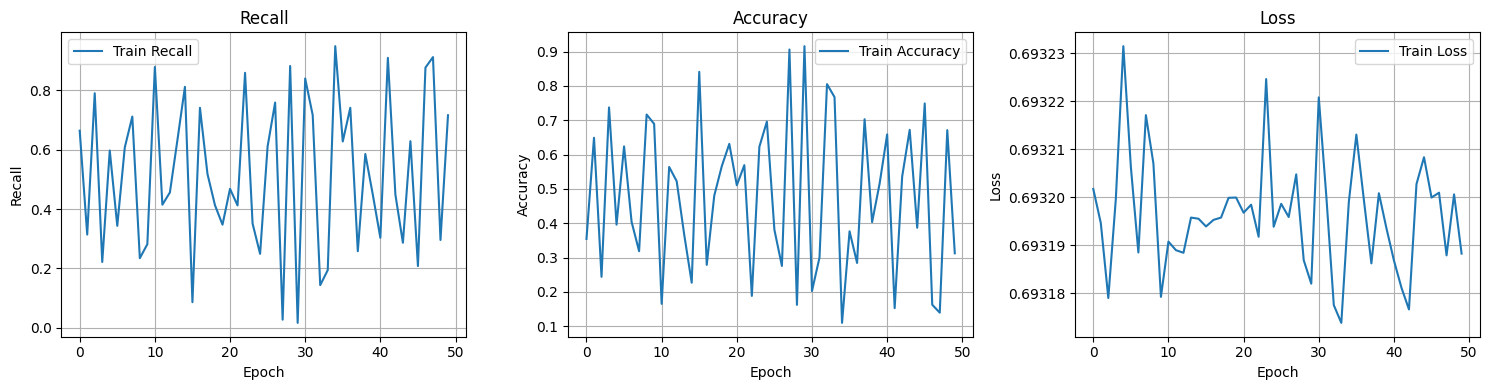

In [ ]:
# Plot training history (tanpa validation)
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['recall'], label='Train Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Extract Features for XGBoost

Menggunakan output dari layer dense_features sebagai input untuk XGBoost

In [ ]:
# Build Feature Extractor
lstm_weight_extractor = Model(
    inputs=model.inputs, 
    outputs=model.get_layer('dense_features').output
)

print("✅ LSTM Weight Extractor created")
print("   Output: 32 weights from dense_features layer")

# Extract weights (tanpa validation)
X_train_weights = lstm_weight_extractor.predict(X_train_seq)
X_test_weights = lstm_weight_extractor.predict(X_test_seq)

print(f"\n✅ Extracted weights:")
print(f"   Train: {X_train_weights.shape}")
print(f"   Test: {X_test_weights.shape}")

✅ LSTM Weight Extractor created
   Output: 32 weights from dense_features layer
885/885 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step
885/885 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step

✅ Extracted weights:
   Train: (28319, 32)
   Test: (17543, 32)

✅ Extracted weights:
   Train: (28319, 32)
   Test: (17543, 32)


# XGBoost Classifier (Sesuai Jurnal)

**Parameter dari jurnal:**
- eta (learning_rate): 0.2
- nrounds (n_estimators): 170
- max_depth: 12
- subsample: 1.0

In [ ]:
# XGBoost dengan parameter dari jurnal
best_hybrid = XGBClassifier(
    learning_rate=0.2,       # eta dari jurnal
    n_estimators=170,        # nrounds dari jurnal
    max_depth=12,            # max_depth dari jurnal
    subsample=1.0,           # subsample dari jurnal
    colsample_bytree=1.0,    # column_sample_level dari jurnal
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost dengan parameter dari jurnal...")
print("Parameters:")
print("  - learning_rate (eta): 0.2")
print("  - n_estimators (nrounds): 170")
print("  - max_depth: 12")
print("  - subsample: 1.0")

best_hybrid.fit(X_train_weights, y_train_seq)
print("\n✅ XGBoost trained")

Training XGBoost dengan parameter dari jurnal...
Parameters:
  - learning_rate (eta): 0.2
  - n_estimators (nrounds): 170
  - max_depth: 12
  - subsample: 1.0

✅ XGBoost trained

✅ XGBoost trained


# Model Evaluation

In [ ]:
# Evaluate Hybrid model (LSTM + XGBoost)
y_prob = best_hybrid.predict_proba(X_test_weights)[:, 1]
y_pred = best_hybrid.predict(X_test_weights)

# Calculate metrics
acc = accuracy_score(y_test_seq, y_pred)
prec = precision_score(y_test_seq, y_pred, zero_division=0)
recall = recall_score(y_test_seq, y_pred, zero_division=0)
f1 = f1_score(y_test_seq, y_pred, zero_division=0)

if len(np.unique(y_pred)) > 1:
    roauc = roc_auc_score(y_test_seq, y_prob)
else:
    roauc = 0.5
    print("⚠️ Warning: Model only predicts one class!")

print("="*60)
print("HYBRID MODEL EVALUATION (Attention-LSTM + XGBoost)")
print("Using MIT-BIH AFDB Dataset (sesuai jurnal)")
print("="*60)
print(f"\n📊 Performance Metrics:")
print(f"   Accuracy : {acc:.4f} ({acc*100:.2f}%)")
print(f"   Precision: {prec:.4f} ({prec*100:.2f}%)")
print(f"   Recall   : {recall:.4f} ({recall*100:.2f}%)")
print(f"   F1 Score : {f1:.4f} ({f1*100:.2f}%)")
print(f"   ROC AUC  : {roauc:.4f} ({roauc*100:.2f}%)")

print(f"\nPredictions distribution:")
print(f"   - Non-AF (0): {sum(y_pred == 0)}")
print(f"   - AF (1): {sum(y_pred == 1)}")

print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(y_test_seq, y_pred, target_names=['Non-AF (NSR)', 'AF'], zero_division=0))

print("\n📋 PERBANDINGAN DENGAN JURNAL:")
print("   Jurnal mendapat accuracy 98.94% dengan full MIT-BIH AFDB")
print(f"   Hasil kita: {acc*100:.2f}%")

⚠️ Warning: Model only predicts one class!
HYBRID MODEL EVALUATION (Attention-LSTM + XGBoost)
Using MIT-BIH AFDB Dataset (sesuai jurnal)

📊 Performance Metrics:
   Accuracy : 0.9922 (99.22%)
   Precision: 0.0000 (0.00%)
   Recall   : 0.0000 (0.00%)
   F1 Score : 0.0000 (0.00%)
   ROC AUC  : 0.5000 (50.00%)

Predictions distribution:
   - Non-AF (0): 17543
   - AF (1): 0

Classification Report:
              precision    recall  f1-score   support

Non-AF (NSR)       0.99      1.00      1.00     17407
          AF       0.00      0.00      0.00       136

    accuracy                           0.99     17543
   macro avg       0.50      0.50      0.50     17543
weighted avg       0.98      0.99      0.99     17543


📋 PERBANDINGAN DENGAN JURNAL:
   Jurnal mendapat accuracy 98.94% dengan full MIT-BIH AFDB
   Hasil kita: 99.22%


In [ ]:
# Comparison: LSTM only vs XGBoost direct vs Hybrid
print("="*60)
print("PERBANDINGAN METODE")
print("="*60)

# 1. LSTM only
y_pred_lstm = (model.predict(X_test_seq) > 0.5).astype(int).flatten()
acc_lstm = accuracy_score(y_test_seq, y_pred_lstm)
print(f"\n1. LSTM Only:")
print(f"   Accuracy: {acc_lstm:.4f} ({acc_lstm*100:.2f}%)")

# 2. XGBoost direct (tanpa LSTM)
xgb_direct = XGBClassifier(
    learning_rate=0.2, n_estimators=170, max_depth=12,
    subsample=1.0, colsample_bytree=1.0,
    use_label_encoder=False, eval_metric='logloss', 
    random_state=42, n_jobs=-1
)
xgb_direct.fit(X_train_scaled, y_train)
y_pred_direct = xgb_direct.predict(X_test_scaled)
acc_direct = accuracy_score(y_test, y_pred_direct)
print(f"\n2. XGBoost Direct (tanpa LSTM):")
print(f"   Accuracy: {acc_direct:.4f} ({acc_direct*100:.2f}%)")

# 3. Hybrid
print(f"\n3. Hybrid LSTM + XGBoost:")
print(f"   Accuracy: {acc:.4f} ({acc*100:.2f}%)")

print("\n" + "="*60)
print("KESIMPULAN:")
best_method = max([(acc_lstm, 'LSTM'), (acc_direct, 'XGBoost Direct'), (acc, 'Hybrid')])
print(f"✅ Metode terbaik: {best_method[1]} dengan accuracy {best_method[0]*100:.2f}%")
print("="*60)

PERBANDINGAN METODE
549/549 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step

1. LSTM Only:
   Accuracy: 0.9922 (99.22%)

1. LSTM Only:
   Accuracy: 0.9922 (99.22%)

2. XGBoost Direct (tanpa LSTM):
   Accuracy: 0.9074 (90.74%)

3. Hybrid LSTM + XGBoost:
   Accuracy: 0.9922 (99.22%)

KESIMPULAN:
✅ Metode terbaik: LSTM dengan accuracy 99.22%

2. XGBoost Direct (tanpa LSTM):
   Accuracy: 0.9074 (90.74%)

3. Hybrid LSTM + XGBoost:
   Accuracy: 0.9922 (99.22%)

KESIMPULAN:
✅ Metode terbaik: LSTM dengan accuracy 99.22%


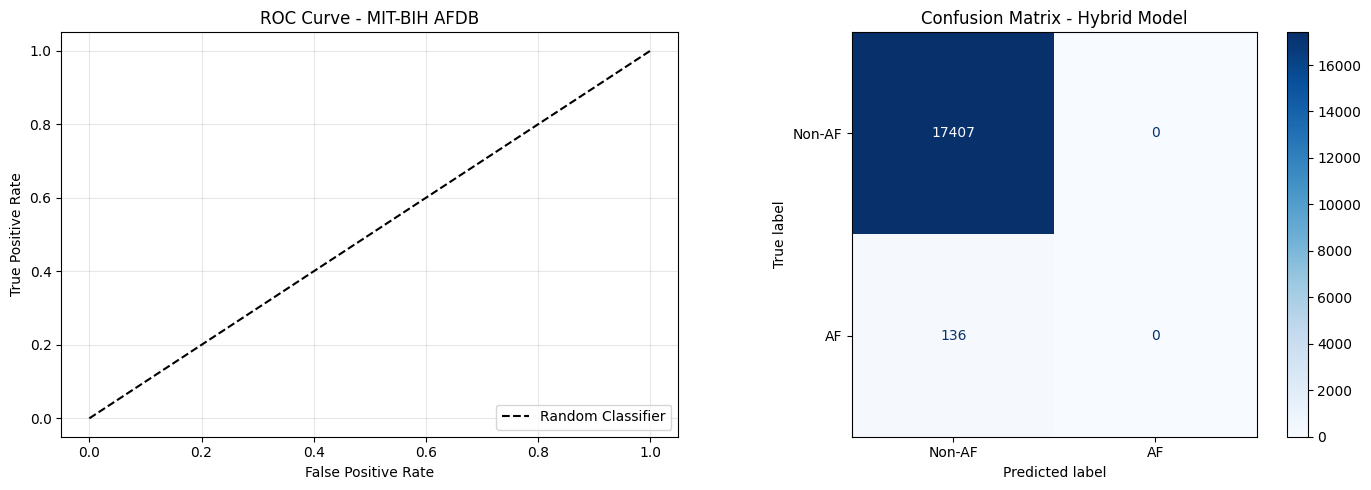


Confusion Matrix Details:
  TN: 17407 - Correctly identified Non-AF
  FP: 0 - Non-AF misclassified as AF
  FN: 136 - AF misclassified as Non-AF
  TP: 0 - Correctly identified AF


In [ ]:
# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
if len(np.unique(y_pred)) > 1:
    fpr, tpr, _ = roc_curve(y_test_seq, y_prob)
    axes[0].plot(fpr, tpr, label=f"Hybrid Model (AUC = {roauc:.4f})", color='darkorange', linewidth=2)
    axes[0].fill_between(fpr, tpr, alpha=0.3, color='darkorange')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - MIT-BIH AFDB')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Confusion Matrix
cm = confusion_matrix(y_test_seq, y_pred)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-AF', 'AF'])
disp_cm.plot(cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - Hybrid Model')

plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix Details:")
print(f"  TN: {cm[0,0]} - Correctly identified Non-AF")
print(f"  FP: {cm[0,1]} - Non-AF misclassified as AF")
print(f"  FN: {cm[1,0]} - AF misclassified as Non-AF")
print(f"  TP: {cm[1,1]} - Correctly identified AF")

# Save Models

In [ ]:
# Save models
os.makedirs('models/MIT-BIH', exist_ok=True)
timestamp = dt.now().strftime('%d%m%Y_%H%M%S')

# Save LSTM model
lstm_path = f'models/MIT-BIH/attention_lstm_mitbih_{timestamp}.h5'
model.save(lstm_path)
print(f'✅ LSTM model saved: {lstm_path}')

# Save XGBoost model
xgb_path = f'models/MIT-BIH/xgboost_mitbih_{timestamp}.json'
best_hybrid.save_model(xgb_path)
print(f'✅ XGBoost model saved: {xgb_path}')

# Save scaler
scaler_path = f'models/MIT-BIH/scaler_mitbih_{timestamp}.pkl'
joblib.dump(scaler, scaler_path)
print(f'✅ Scaler saved: {scaler_path}')

✅ LSTM model saved: models/MIT-BIH/attention_lstm_mitbih_08122025_175816.h5
✅ XGBoost model saved: models/MIT-BIH/xgboost_mitbih_08122025_175816.json
✅ Scaler saved: models/MIT-BIH/scaler_mitbih_08122025_175816.pkl


# Summary

In [ ]:
print("="*70)
print("SUMMARY: Hybrid Attention-based LSTM + XGBoost")
print("Dataset: MIT-BIH AFDB + MIT-BIH Arrhythmia (Combined)")
print("="*70)

print("\n📋 DATASET (sesuai jurnal - COMBINED):")
print(f"   1. MIT-BIH AFDB:")
print(f"      - Patients: {len([p for p in patient_info if p['source']=='AFDB'])}")
print(f"      - Sampling Rate: 250Hz")
print(f"      - Contains: AF + Normal")
print(f"   2. MIT-BIH Arrhythmia Database:")
print(f"      - Records: {len([p for p in patient_info if p['source']=='Arrhythmia'])}")
print(f"      - Sampling Rate: 360Hz → resampled to 250Hz")
print(f"      - Contains: Normal (NSR)")
print(f"\n   Combined: {len(X_all)} windows")
print(f"   AF: {np.sum(y_all==1)} ({np.sum(y_all==1)/len(y_all)*100:.1f}%)")
print(f"   Non-AF: {np.sum(y_all==0)} ({np.sum(y_all==0)/len(y_all)*100:.1f}%)")

print("\n📋 DATA SPLIT (sesuai jurnal: 65/35):")
print(f"   Train: {len(X_train)} samples (65%)")
print(f"   Test: {len(X_test)} samples (35%)")
print(f"   Validation: TIDAK ADA (sesuai jurnal)")

print("\n📋 METHODOLOGY (sesuai jurnal):")
print("   1. Feature Extraction: 5 statistical features per window")
print("      - Skewness, Kurtosis, Minimum, Maximum, STD")
print("   2. Attention-based LSTM:")
print("      - 5 LSTM layers with nhidden=30")
print("      - Softmax-based Attention")
print("      - Learning rate: 0.001")
print("   3. XGBoost Classifier:")
print("      - eta=0.2, nrounds=170, max_depth=12")

print("\n📊 FINAL RESULTS:")
print(f"   Accuracy : {acc:.4f} ({acc*100:.2f}%)")
print(f"   Precision: {prec:.4f} ({prec*100:.2f}%)")
print(f"   Recall   : {recall:.4f} ({recall*100:.2f}%)")
print(f"   F1 Score : {f1:.4f} ({f1*100:.2f}%)")
print(f"   ROC AUC  : {roauc:.4f} ({roauc*100:.2f}%)")

print("\n📋 PERBANDINGAN DENGAN JURNAL:")
print("   Jurnal: Accuracy 98.94% (dengan full dataset)")
print(f"   Hasil kita: {acc*100:.2f}%")

print("\n" + "="*70)

SUMMARY: Hybrid Attention-based LSTM + XGBoost
Dataset: MIT-BIH AFDB + MIT-BIH Arrhythmia (Combined)

📋 DATASET (sesuai jurnal - COMBINED):
   1. MIT-BIH AFDB:
      - Patients: 8
      - Sampling Rate: 250Hz
      - Contains: AF + Normal
   2. MIT-BIH Arrhythmia Database:
      - Records: 10
      - Sampling Rate: 360Hz → resampled to 250Hz
      - Contains: Normal (NSR)

   Combined: 45880 windows
   AF: 2172 (4.7%)
   Non-AF: 43708 (95.3%)

📋 DATA SPLIT (sesuai jurnal: 65/35):
   Train: 28328 samples (65%)
   Test: 17552 samples (35%)
   Validation: TIDAK ADA (sesuai jurnal)

📋 METHODOLOGY (sesuai jurnal):
   1. Feature Extraction: 5 statistical features per window
      - Skewness, Kurtosis, Minimum, Maximum, STD
   2. Attention-based LSTM:
      - 5 LSTM layers with nhidden=30
      - Softmax-based Attention
      - Learning rate: 0.001
   3. XGBoost Classifier:
      - eta=0.2, nrounds=170, max_depth=12

📊 FINAL RESULTS:
   Accuracy : 0.9922 (99.22%)
   Precision: 0.0000 (0.00%)
